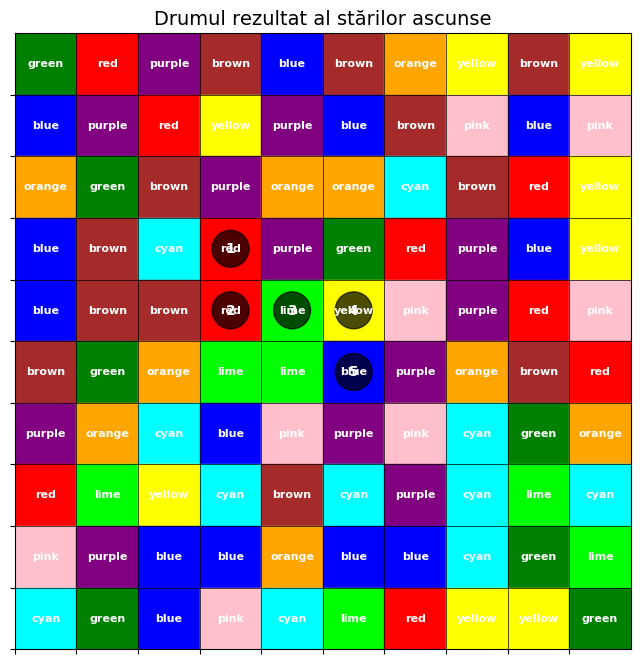

Log-probabilitate: -10.150347630467653
Drumul cel mai probabil: [(3, 3), (4, 3), (4, 4), (4, 5), (5, 5)]


In [ ]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dimensiunea gridului
dimensiune_grid = (10, 10)

# Lista de culori predefinite
culori = [
    "red", "blue", "green", "yellow", 
    "purple", "orange", "pink", "cyan", 
    "brown", "lime"
]

# Citirea gridului
df = pd.read_csv('grid_culori.csv', header=None)
grid_culori = df.to_numpy()

# Generarea secvenței de culori observate
observatii = ["red", "red", "lime", "yellow", "blue"]

# Mapare culori -> indecși
culoare_to_idx = {culoare: idx for idx, culoare in enumerate(culori)}
idx_to_culoare = {idx: culoare for culoare, idx in culoare_to_idx.items()}

# Transformăm secvența de observații în indecși
observatii_idx = [culoare_to_idx[c] for c in observatii]

# Definim stările ascunse ca fiind toate pozițiile din grid (100 de stări)
numar_stari = dimensiune_grid[0] * dimensiune_grid[1]
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0]) for j in range(dimensiune_grid[1])]
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}

# Matrice de tranziție
transitions = np.zeros((numar_stari, numar_stari))

for i, j in stari_ascunse:
    # Daca eliminam probaiblitatea ca agentul sa ramana pe loc vom avea urmatoarea matrice 
    # de tranzitie. VEDETI imaginea "subiect1-2.png"
    # decomentati codul de jos si commentati ce este intre "----" 
    

    # vecini = [
    #     (i - 1, j),   # sus
    #     (i + 1, j),   # jos
    #     (i, j - 1),   # stânga
    #     (i, j + 1)    # dreapta
    # ]
    # vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]
    # prob_rest = 1.0 / len(vecini_valizi)
    
    # for vecin in vecini_valizi:
    #     transitions[stare_to_idx[(i, j)], vecin] = prob_rest
    
    # ----
    
    vecini = [
        (i, j),       # rămâne
        (i - 1, j),   # sus
        (i + 1, j),   # jos
        (i, j - 1),   # stânga
        (i, j + 1)    # dreapta
    ]
    
    vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]
    prob_rest = 0.75 / (len(vecini_valizi) - 1)
    
    for vecin in vecini_valizi:
        if vecin == stare_to_idx[(i, j)]: # probabilitatea de a rămâne
            transitions[stare_to_idx[(i, j)], vecin] = 0.25
        else:
            transitions[stare_to_idx[(i, j)], vecin] = prob_rest
    
    # ----

# Normalizăm matricea de tranziție
transitions = transitions / transitions.sum(axis=1, keepdims=True)

# Matrice de emisie
emissions = np.zeros((numar_stari, len(culori)))

for i, j in stari_ascunse:
    culoare = grid_culori[i, j]
    emissions[stare_to_idx[(i, j)], culoare_to_idx[culoare]] = 1.0

# Modelul HMM
model = hmm.CategoricalHMM(n_components=numar_stari, n_iter=100, verbose=True)
model.startprob_ = np.ones(numar_stari) / numar_stari
model.transmat_ = transitions
model.emissionprob_ = emissions

# Rulăm algoritmul Viterbi pentru secvența de observații
logprob, secventa_stari = model.decode(np.array(observatii_idx).reshape(-1, 1), algorithm="viterbi")

# Convertim secvența de stări în poziții din grid
drum = [idx_to_stare[idx] for idx in secventa_stari]

# Vizualizăm drumul rezultat pe grid
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(dimensiune_grid[0]):
    for j in range(dimensiune_grid[1]):
        culoare = grid_culori[i, j]
        ax.add_patch(plt.Rectangle((j, dimensiune_grid[0] - i - 1), 1, 1, color=culoare))
        ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, culoare, 
                color="white", ha="center", va="center", fontsize=8, fontweight="bold")

# Evidențiem drumul rezultat
for idx, (i, j) in enumerate(drum):
    ax.add_patch(plt.Circle((j + 0.5, dimensiune_grid[0] - i - 0.5), 0.3, color="black", alpha=0.7))
    ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, str(idx + 1), 
            color="white", ha="center", va="center", fontsize=10, fontweight="bold")

# Setări axă
ax.set_xlim(0, dimensiune_grid[1])
ax.set_ylim(0, dimensiune_grid[0])
ax.set_xticks(range(dimensiune_grid[1]))
ax.set_yticks(range(dimensiune_grid[0]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(visible=True, color="black", linewidth=0.5)
ax.set_aspect("equal")
plt.title("Drumul rezultat al stărilor ascunse", fontsize=14)
plt.show()

# Rezultate
print("Log-probabilitate:", logprob)
print("Drumul cel mai probabil:", drum)
